In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from math import radians, cos, sin, asin, sqrt

In [2]:
df = pd.read_csv('../data/train.zip', compression='zip')

In [3]:
display(df.head())
print 'Counts of id', df.id.count(), df.id.nunique()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Counts of id 1458644 1458644


In [15]:
# get datetime features
weekday_name_dict = {
    0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'
}
for dt in ['pickup_datetime', 'dropoff_datetime']:
    df[dt] = pd.to_datetime(df[dt])
    df['{}_day'.format(dt.split('_')[0])] = df[dt].apply(lambda x: x.weekday()).replace(weekday_name_dict)
    df['{}_hour'.format(dt.split('_')[0])] = df[dt].apply(lambda x: x.hour)

In [22]:
# get distance from lat long
def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km
df['dist_kms'] = df.apply(haversine, axis=1)

In [7]:
# get direction from lat long
def bearing_array(row):
    """
        Returns bearing direction b/w origin and destination
    """
    lon1, lat1, lon2, lat2 = map(radians, [
        row['pickup_longitude'],
        row['pickup_latitude'],
        row['dropoff_longitude'],
        row['dropoff_latitude']
        ])
    AVG_EARTH_RADIUS = 6371  # in km
    lon_delta_rad = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))
df['direction'] = df.apply(bearing_array, axis=1)

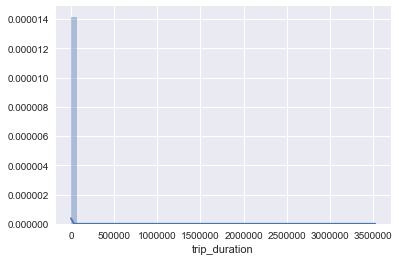

In [5]:
# trip duration distribution
sns.distplot(df['trip_duration'])
# plt.xlim(-10, 8000)
plt.show()

In [67]:
df['trip_duration'].describe().round(2)

count    1458644.00
mean         959.49
std         5237.43
min            1.00
25%          397.00
50%          662.00
75%         1075.00
max      3526282.00
Name: trip_duration, dtype: float64

In [10]:
# remove outliers from trip duration
avg_d = df['trip_duration'].mean() 
dev_d = df['trip_duration'].std()
df = df[df.trip_duration < (avg_d + 3*dev_d)]
df['trip_duration'].describe().round(2)

count    1456571.00
mean         837.12
std          661.37
min            1.00
25%          397.00
50%          662.00
75%         1073.00
max        15900.00
Name: trip_duration, dtype: float64

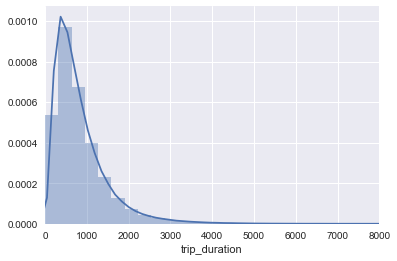

In [81]:
# trip duration distribution
sns.distplot(df['trip_duration'])
plt.xlim(-10, 8000)
plt.show()

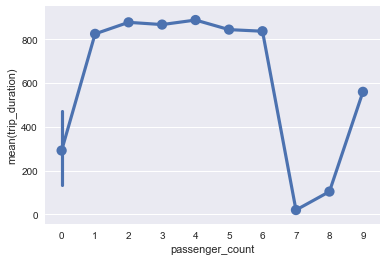

In [82]:
sns.pointplot(df['passenger_count'], df['trip_duration'])
plt.show()

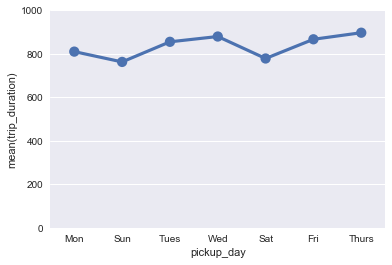

In [18]:
sns.pointplot(df['pickup_day'], df['trip_duration'])
plt.ylim([0, 1000])
plt.show()

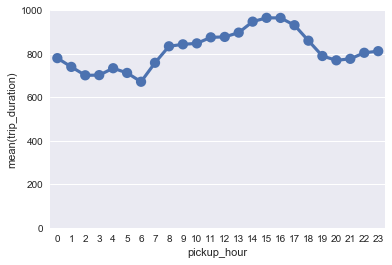

In [19]:
sns.pointplot(df['pickup_hour'], df['trip_duration'])
plt.ylim([0, 1000])
plt.show()

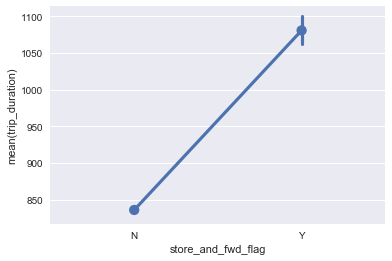

In [85]:
sns.pointplot(df['store_and_fwd_flag'], df['trip_duration'])
plt.show()

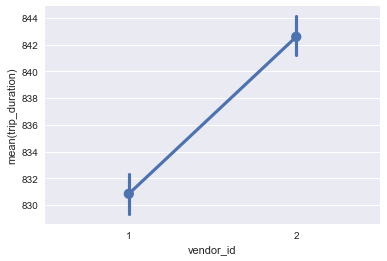

In [86]:
sns.pointplot(df['vendor_id'], df['trip_duration'])
plt.show()

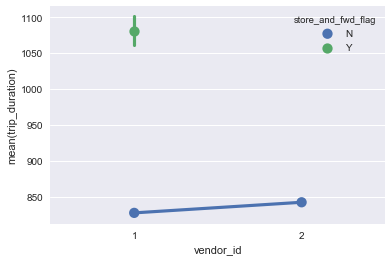

In [87]:
sns.pointplot(df['vendor_id'], df['trip_duration'], df['store_and_fwd_flag'])

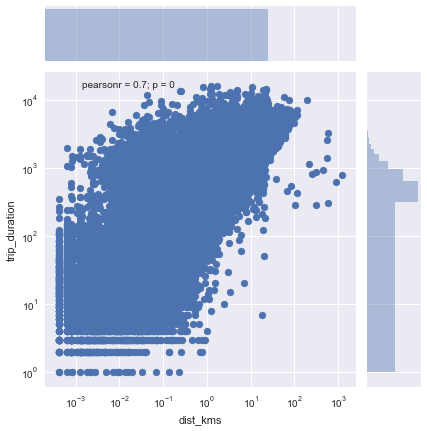

In [88]:
g = sns.jointplot(df['dist_kms'], df['trip_duration'])
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

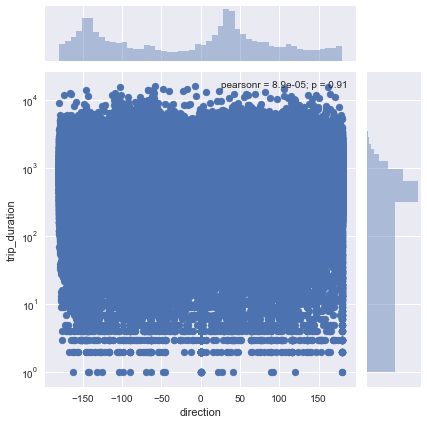

In [12]:
g = sns.jointplot(df['direction'], df['trip_duration'])
ax = g.ax_joint
# ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [23]:
df[[u'passenger_count', u'store_and_fwd_flag',
    u'trip_duration', u'direction', u'pickup_day', u'pickup_hour',
    u'dropoff_day', u'dropoff_hour', 'dist_kms']].corr()

,passenger_count,trip_duration,direction,pickup_hour,dropoff_hour,dist_kms
passenger_count,1.000000,0.014942,-0.000754,0.009138,0.008524,0.010228
trip_duration,0.014942,1.000000,0.000089,0.029499,0.035008,0.703774
direction,-0.000754,0.000089,1.000000,-0.022119,-0.027876,0.001994
pickup_hour,0.009138,0.029499,-0.022119,1.000000,0.934120,-0.015815
dropoff_hour,0.008524,0.035008,-0.027876,0.934120,1.000000,-0.020671
dist_kms,0.010228,0.703774,0.001994,-0.015815,-0.020671,1.000000
